In [2]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
import xgboost as xgb

pl.Config.set_fmt_str_lengths(50)
delivery_data = pl.read_csv('/Users/ryanquach/Downloads/delivery_data.csv')

In [3]:
delivery_data.head()

ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
str,str,str,str,f64,f64,f64,f64,str,str,str,str,str,i64,str,str,str,str,str,str
"""0x4607 ""","""INDORES13DEL02 ""","""37""","""4.9""",22.745049,75.892471,22.765049,75.912471,"""19-03-2022""","""11:30:00""","""11:45:00""","""conditions Sunny""","""High """,2,"""Snack ""","""motorcycle ""","""0""","""No ""","""Urban ""","""(min) 24"""
"""0xb379 ""","""BANGRES18DEL02 ""","""34""","""4.5""",12.913041,77.683237,13.043041,77.813237,"""25-03-2022""","""19:45:00""","""19:50:00""","""conditions Stormy""","""Jam """,2,"""Snack ""","""scooter ""","""1""","""No ""","""Metropolitian ""","""(min) 33"""
"""0x5d6d ""","""BANGRES19DEL01 ""","""23""","""4.4""",12.914264,77.6784,12.924264,77.6884,"""19-03-2022""","""08:30:00""","""08:45:00""","""conditions Sandstorms""","""Low """,0,"""Drinks ""","""motorcycle ""","""1""","""No ""","""Urban ""","""(min) 26"""
"""0x7a6a ""","""COIMBRES13DEL02 ""","""38""","""4.7""",11.003669,76.976494,11.053669,77.026494,"""05-04-2022""","""18:00:00""","""18:10:00""","""conditions Sunny""","""Medium """,0,"""Buffet ""","""motorcycle ""","""1""","""No ""","""Metropolitian ""","""(min) 21"""
"""0x70a2 ""","""CHENRES12DEL01 ""","""32""","""4.6""",12.972793,80.249982,13.012793,80.289982,"""26-03-2022""","""13:30:00""","""13:45:00""","""conditions Cloudy""","""High """,1,"""Snack ""","""scooter ""","""1""","""No ""","""Metropolitian ""","""(min) 30"""


## Data Cleaning

In [4]:
def haversine(long_start, lat_start, long_end, lat_end):
    long_start, lat_start, long_end, lat_end = map(np.radians, [long_start, lat_start, long_end, lat_end])
    
    long_dist = long_end - long_start 
    lat_dist = lat_end - lat_start 
    a = np.sin(lat_dist/2) ** 2 + np.cos(lat_start) * np.cos(lat_end) * np.sin(long_dist/2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    km = 6371 * c
    return km

delivery_data = (delivery_data
                .select(pl.exclude(['ID', 'Delivery_person_ID', 'Vehicle_condition', 'Order_Date', 
                                    'Time_Orderd', 'Time_Order_picked', 'multiple_deliveries']))
                .select(pl.all().name.map(lambda col_name: col_name.lower()))
                .rename({'restaurant_latitude': 'orig_lat',
                         'restaurant_longitude': 'orig_long',
                         'delivery_location_latitude': 'dest_lat',
                         'delivery_location_longitude': 'dest_long',
                         'weatherconditions': 'weather',
                         'road_traffic_density': 'traffic_density',
                         'time_taken(min)': 'time_taken'})
                .with_columns([pl.col('weather').str.to_lowercase().str.replace('conditions ', ''),
                               pl.col('type_of_order').str.to_lowercase().str.strip_chars(),
                               pl.col('traffic_density').str.to_lowercase().str.strip_chars(),
                               pl.col('type_of_vehicle').str.strip_chars(),
                               pl.col('festival').str.to_lowercase().str.strip_chars(),
                               pl.col('city').str.to_lowercase().str.strip_chars(),
                               pl.col('time_taken').str.replace('\(min\) ', '')])    
                .with_columns(haversine(pl.col('orig_long'), pl.col('orig_lat'), 
                                        pl.col('dest_long'), pl.col('dest_lat')).alias('distance').round(2))
                .with_columns([pl.col('delivery_person_age').str.replace('NaN ', '10000').cast(pl.Int16),
                               pl.col('delivery_person_ratings').str.replace('NaN ', '10000').cast(pl.Float32),
                               pl.col('distance').str.replace('NaN ', '10000').cast(pl.Float32).round(2),
                               pl.col('time_taken').str.replace('NaN ', '10000').cast(pl.Int16)])
                .select(pl.exclude(['orig_lat', 'orig_long', 'dest_lat', 'dest_long']))
                .select(pl.exclude('time_taken'), pl.col('time_taken'))
                )

delivery_data.head(n = 10)

delivery_person_age,delivery_person_ratings,weather,traffic_density,type_of_order,type_of_vehicle,festival,city,distance,time_taken
i16,f32,str,str,str,str,str,str,f32,i16
37,4.9,"""sunny""","""high""","""snack""","""motorcycle""","""no""","""urban""",3.03,24
34,4.5,"""stormy""","""jam""","""snack""","""scooter""","""no""","""metropolitian""",20.18,33
23,4.4,"""sandstorms""","""low""","""drinks""","""motorcycle""","""no""","""urban""",1.55,26
38,4.7,"""sunny""","""medium""","""buffet""","""motorcycle""","""no""","""metropolitian""",7.79,21
32,4.6,"""cloudy""","""high""","""snack""","""scooter""","""no""","""metropolitian""",6.21,30
22,4.8,"""cloudy""","""jam""","""buffet""","""motorcycle""","""no""","""urban""",4.61,26
33,4.7,"""fog""","""jam""","""meal""","""scooter""","""no""","""metropolitian""",16.6,40
35,4.6,"""cloudy""","""medium""","""meal""","""motorcycle""","""no""","""metropolitian""",20.209999,32
22,4.8,"""stormy""","""jam""","""buffet""","""motorcycle""","""no""","""metropolitian""",19.98,34


In [5]:
delivery_data = delivery_data.filter(~pl.col('weather').str.contains('nan'),
                                     ~pl.col('traffic_density').str.contains('nan'),
                                     ~pl.col('type_of_order').str.contains('nan'),
                                     ~pl.col('type_of_vehicle').str.contains('nan'),
                                     ~pl.col('festival').str.contains('nan'),
                                     ~pl.col('city').str.contains('nan'),
                                     ~(pl.col('delivery_person_age') == 10000.0), 
                                     ~(pl.col('delivery_person_ratings') == 10000.0),
                                     ~(pl.col('distance') == 10000.0),
                                     ~(pl.col('time_taken') == 10000.0))

In [6]:
delivery_data.describe()

describe,delivery_person_age,delivery_person_ratings,weather,traffic_density,type_of_order,type_of_vehicle,festival,city,distance,time_taken
str,f64,f64,str,str,str,str,str,str,f64,f64
"""count""",42260.0,42260.0,"""42260""","""42260""","""42260""","""42260""","""42260""","""42260""",42260.0,42260.0
"""null_count""",0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0
"""mean""",29.597089,4.633897,null,null,null,null,null,null,26.834864,26.475982
"""std""",5.762773,0.315244,null,null,null,null,null,null,298.865143,9.335128
"""min""",20.0,2.5,"""cloudy""","""high""","""buffet""","""electric_scooter""","""no""","""metropolitian""",1.47,10.0
"""25%""",25.0,4.5,null,null,null,null,null,null,4.66,19.0
"""50%""",30.0,4.7,null,null,null,null,null,null,9.22,26.0
"""75%""",35.0,4.9,null,null,null,null,null,null,13.68,33.0
"""max""",39.0,5.0,"""windy""","""medium""","""snack""","""scooter""","""yes""","""urban""",6884.72998,54.0


In [7]:
delivery_data.head(n = 10)

delivery_person_age,delivery_person_ratings,weather,traffic_density,type_of_order,type_of_vehicle,festival,city,distance,time_taken
i16,f32,str,str,str,str,str,str,f32,i16
37,4.9,"""sunny""","""high""","""snack""","""motorcycle""","""no""","""urban""",3.03,24
34,4.5,"""stormy""","""jam""","""snack""","""scooter""","""no""","""metropolitian""",20.18,33
23,4.4,"""sandstorms""","""low""","""drinks""","""motorcycle""","""no""","""urban""",1.55,26
38,4.7,"""sunny""","""medium""","""buffet""","""motorcycle""","""no""","""metropolitian""",7.79,21
32,4.6,"""cloudy""","""high""","""snack""","""scooter""","""no""","""metropolitian""",6.21,30
22,4.8,"""cloudy""","""jam""","""buffet""","""motorcycle""","""no""","""urban""",4.61,26
33,4.7,"""fog""","""jam""","""meal""","""scooter""","""no""","""metropolitian""",16.6,40
35,4.6,"""cloudy""","""medium""","""meal""","""motorcycle""","""no""","""metropolitian""",20.209999,32
22,4.8,"""stormy""","""jam""","""buffet""","""motorcycle""","""no""","""metropolitian""",19.98,34


## Data Visualization

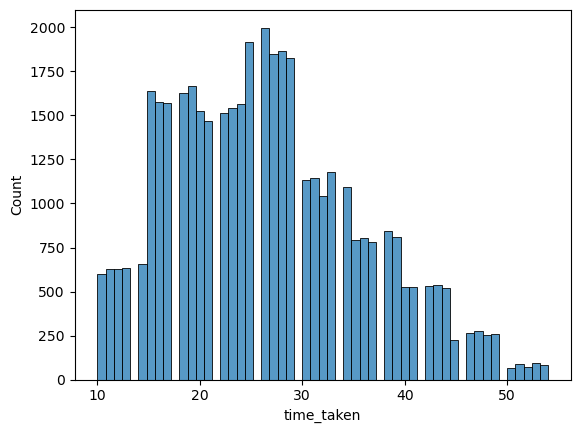

In [8]:
sns.histplot(data = delivery_data.to_pandas(), x = 'time_taken');

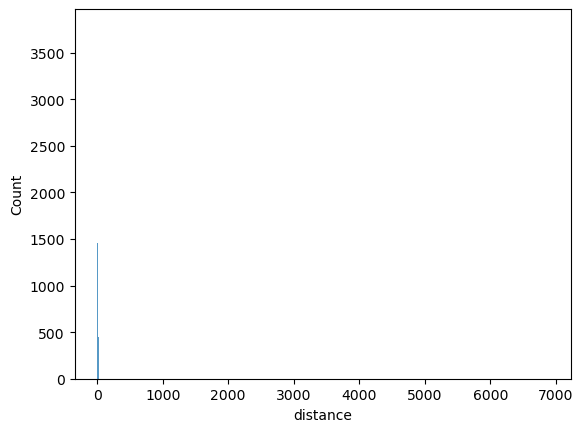

In [9]:
sns.histplot(data = delivery_data.to_pandas(), x = 'distance');

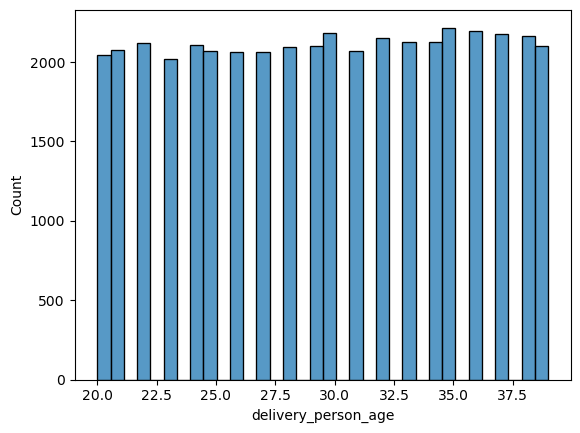

In [10]:
sns.histplot(data = delivery_data.to_pandas(), x = 'delivery_person_age');

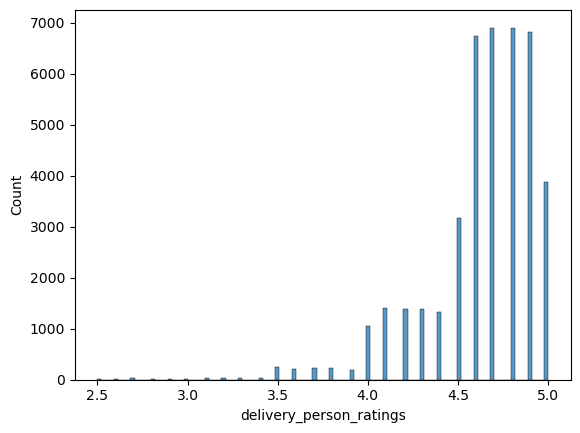

In [11]:
sns.histplot(data = delivery_data.to_pandas(), x = 'delivery_person_ratings');

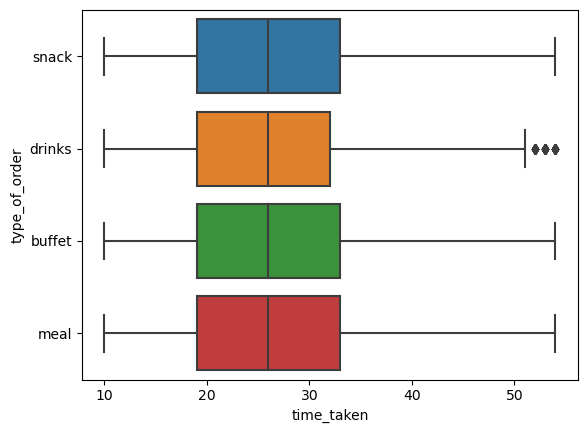

In [12]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'type_of_order');

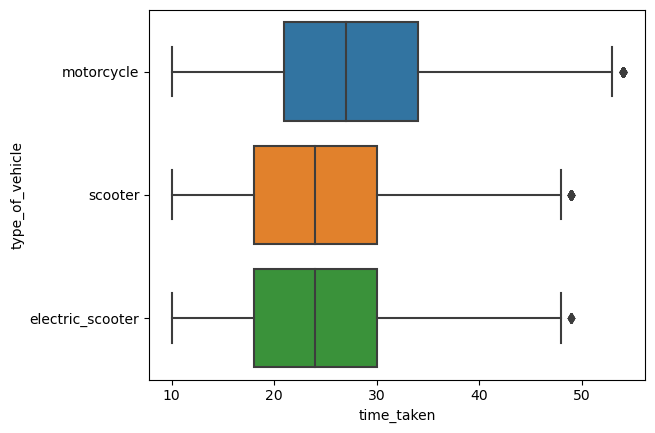

In [13]:
sns.boxplot(data = delivery_data.to_pandas(), x = 'time_taken', y = 'type_of_vehicle');

In [20]:
# sns.scatterplot(data = delivery_data.to_pandas(), x = 'distance', y = 'time_taken');

## Preparing Data for ML Process

In [15]:
data_matrix = delivery_data.to_dummies(pl.selectors.string(), drop_first = True)

In [16]:
data_matrix.head(n = 10)

delivery_person_age,delivery_person_ratings,weather_cloudy,weather_fog,weather_sandstorms,weather_stormy,weather_windy,traffic_density_jam,traffic_density_low,traffic_density_medium,type_of_order_buffet,type_of_order_drinks,type_of_order_meal,type_of_vehicle_electric_scooter,type_of_vehicle_scooter,festival_yes,city_metropolitian,city_semi-urban,distance,time_taken
i16,f32,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,f32,i16
37,4.9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.03,24
34,4.5,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,20.18,33
23,4.4,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1.55,26
38,4.7,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,7.79,21
32,4.6,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,6.21,30
22,4.8,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,4.61,26
33,4.7,0,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,16.6,40
35,4.6,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,20.209999,32
22,4.8,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,19.98,34


In [17]:
X = data_matrix.select(pl.exclude('time_taken')).to_numpy()
Y = data_matrix.select(pl.col('time_taken')).to_numpy()

## Checking for Model Assumptions

In [18]:
mod_check = LinearRegression()
mod_check.fit(X, Y)
mod_pred = mod_check.predict(X)
mod_resid = Y - mod_pred
mod_SR = (mod_resid - np.mean(mod_resid))/np.std(mod_resid)

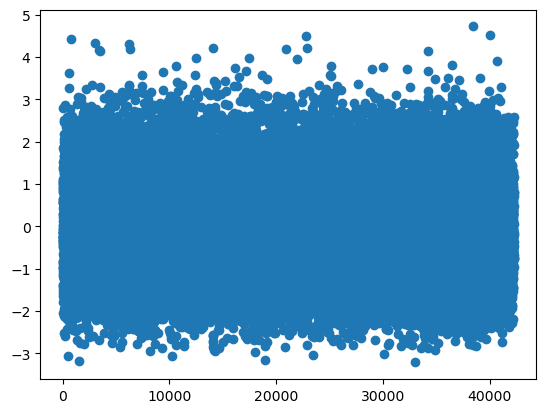

In [22]:
plt.scatter(x = np.arange(1, 42261), y = mod_SR);

In [23]:
print(np.mean(mod_SR))

1.6067585e-08


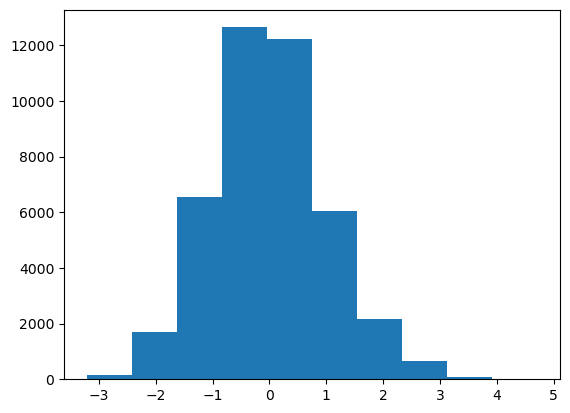

In [24]:
plt.hist(mod_SR);

## Model Creation and Results

In [25]:
mod_lm = LinearRegression()
mod_score = cross_val_score(mod_lm, X, Y, scoring = 'neg_root_mean_squared_error', cv = 5)
mod_score

array([-6.55823183, -6.5523119 , -6.5583272 , -6.47926474, -6.5543642 ])

In [26]:
mod_lasso = Lasso()
mod_score = cross_val_score(mod_lasso, X, Y, scoring = 'neg_root_mean_squared_error', cv = 5)
mod_score

array([-8.39829731, -8.34002972, -8.36645985, -8.18752098, -8.35655594])

In [29]:
mod_ridge = Ridge()
mod_score = cross_val_score(mod_ridge, X, Y, scoring = 'neg_root_mean_squared_error', cv = 5)
mod_score

/Users/ryanquach/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.78671e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/ryanquach/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.53852e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/ryanquach/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.66876e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/ryanquach/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.66033e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/ryanquach/anacond

array([-6.5581646 , -6.55242682, -6.55815697, -6.47922468, -6.55452108])

In [30]:
mod_XGB = xgb.XGBRegressor()
mod_score = cross_val_score(mod_XGB, X, Y, scoring = 'neg_root_mean_squared_error', cv = 5)
mod_score

array([-4.52826691, -4.58191729, -4.58480978, -4.55360889, -4.55386496])